![](header.png)

# Allan Variance

Kevin J. Walchko, Phd

1 Mar 2021

---

An Allan Variance test is a method used for identifying the noise properties of an inertial sensor. 

The method is simple to compute and understand, it is one of the most popular methods today for identifying and quantifying the different noise terms that exist in inertial sensor data. The results from this method are related to five basic noise terms appropriate for inertial sensor data.

1. Quantization Noise
1. Angle Random Walk (ARW): occurs at the intersection of the curve and time = 1 sec
1. Bias Instability: occurs at slope = 0
1. Rate Random Walk
1. Rate Ramp

![](defs.jpg)

![](plot.jpg)

A sensor is mounted statically inside a thermal chamber set to a constant temperature, with data logged at high rate for an extended period (typically several hours). The data is downsampled at various time constants (averaged down to lower sampling rates), and the variances of each of these downsampled measurements can be calculated at each of the different time constants. Despite its name, most of the time the results are plotted as standard deviations (square root of variance) versus the downsampled time constants a log-log scale

![](allan_variance.png)

The plot shown above illustrates two key specifications for an inertial sensor:

1. the Angle Random Walk (equivalent to noise density)
1. the in-run bias stability

How to calculate the ARW shown in the above plot, if you find the intersetion of the curve time = 1 sec, you get around 650 deg/hr: 

$$
\begin{split}
650^\circ/hr &= 650 ^\circ/\sqrt{hr^2} \\
&= 650 ^\circ/\sqrt{3600^2 sec} \\
&= 650 ^\circ/3600/\sqrt{sec} \\
&= 0.18 ^\circ/\sqrt{sec}
\end{split}
$$

Noise density is roughly equal to the standard deviation at an averaging time constant of one second, while the minimum standard deviation value on the plot is the in-run bias stability.

## Algorithm

![](n.png)

```octave
function [T,sigma] = allan(omega,fs,pts)
[N,M] = size(omega); % figure out how big the output data set is
n = 2.^(0:floor(log2(N/2)))'; % determine largest bin size
maxN = n(end);
endLogInc = log10(maxN);
m = unique(ceil(logspace(0,endLogInc,pts)))'; % create log spaced vector average factor
t0 = 1/fs; % t0 = sample interval
T = m*t0; % T = length of time for each cluster
theta = cumsum(omega)/fs; % integration of samples over time to obtain output angle θ
sigma2 = zeros(length(T),M); % array of dimensions (cluster periods) X (#variables)
for i=1:length(m) % loop over the various cluster sizes
    for k=1:N-2*m(i) % implements the summation in the AV equation
        sigma2(i,:) = sigma2(i,:) + (theta(k+2*m(i),:) - 2*theta(k+m(i),:) + theta(k,:)).^2;
    end
end
sigma2 = sigma2./repmat((2*T.^2.*(N-2*m)),1,M);
sigma = sqrt(sigma2) 
```

## References

- [Vectornav](https://www.vectornav.com/resources/inertial-navigation-primer)
- phigets: [Allan Deviation Primer](https://www.phidgets.com/docs/Allan_Deviation_Primer)
- Matlab: [Allan Variance](https://www.mathworks.com/help/nav/ug/inertial-sensor-noise-analysis-using-allan-variance.html)
- Stackexchance: [Allan Variance MEMS Sensor](https://electronics.stackexchange.com/questions/101045/reading-noise-from-allan-variance-plot-for-mems-sensor-per-ieee-std-952-1997)
- Stackexchange: [How to interpret Allan Deviation plot for gyroscope?](https://dsp.stackexchange.com/questions/53970/how-to-interpret-allan-deviation-plot-for-gyroscope)
- arxvi.org: [The TUM VI Benchmark for Evaluating Visual-Inertial Odometry](https://arxiv.org/pdf/1804.06120.pdf)
- [Allan Variance](http://home.engineering.iastate.edu/~shermanp/AERE432/lectures/Rate%20Gyros/Allan%20variance.pdf)
- github: [allan_variance](https://github.com/GAVLab/allan_variance)

In [1]:
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import argparse
from tqdm import tqdm
from collections import namedtuple
from slurm import storage

In [2]:
!ls

allan_variance.png        gyro-accel-3.npy          imu_params.json
allen.ipynb               gyro-accel-3_AllanVar.npy imu_params.yaml
gyro-accel-2.npy          gyro-accel.npy            ins_grd.jpg
gyro-accel-2_AllanVar.npy gyro-accel_AllanVar.npy


Args(numpy_path='./gyro-accel-3.npy', frequency=180.0, windows=30, num_samples=11000, devOrder=0, limWlow=0.0002, limWupp=1, limBlow=100.0, limBupp=300.0)
>> Setting Gyroscope-Accelerometer as data order...
(119227, 7)


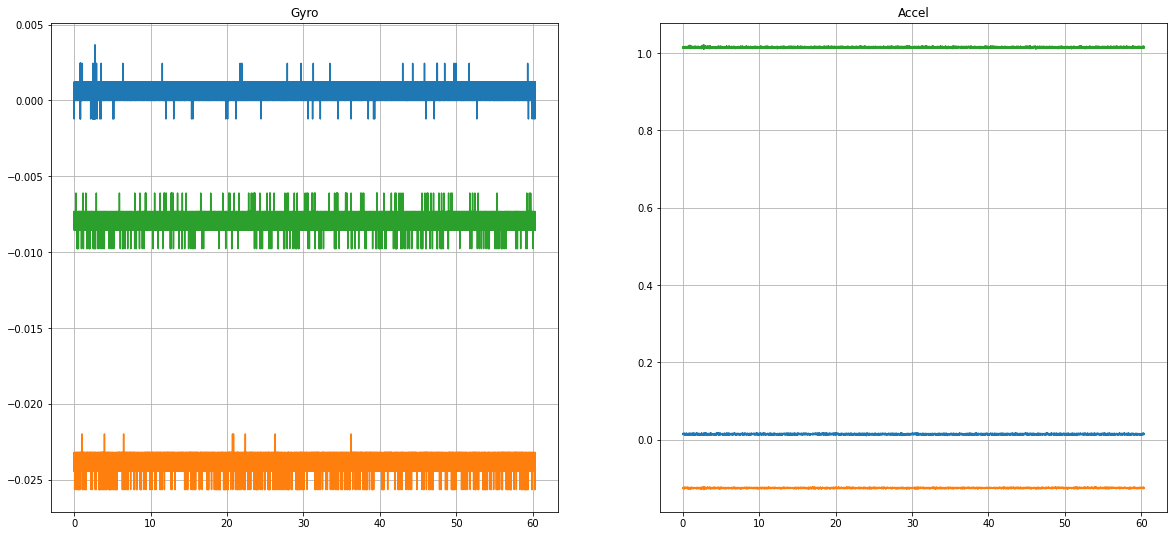

In [89]:
# windows - Minimum windows for the Tau loop
# [limBlow, limBupp] - integration time for bias_b
# [limWlow, limWupp] - integration time for bias_w
Args = namedtuple("Args", "numpy_path frequency windows num_samples devOrder limWlow limWupp limBlow limBupp")
args = Args(
    "./gyro-accel-3.npy", # numpy_path
    180.,               # frequency
    30,                 # windows
    11000,              # num_samples
    0,                  # devOrder
    0.0002,              # limWlow
    1,                 # limWupp
    100.,             # limBlow
    300.              # limBupp
)

print(args)

TAU_0 = 1 / args.frequency
# For each [x,y,z]
# Example: timestamp, gyro_x, gyro_y, gyro_z, accel_x, accel_y, accel_z, (temperature)
if args.devOrder == 0:
    print('>> Setting Gyroscope-Accelerometer as data order...')
    DATA_AXES = {'Acc': [4, 5, 6], 'Gyro': [1, 2, 3]}
else:
    print('>> Setting Accelerometer-Gyroscope as data order...')
    DATA_AXES = {'Acc': [1, 2, 3], 'Gyro': [4, 5, 6]}
    
raw = np.load(args.numpy_path)
print(raw.shape)
raw = raw[:11000,:]

plt.subplots(1,2,figsize=(20,9))
plt.subplot(121)
plt.plot(raw[:,0],raw[:,1])
plt.plot(raw[:,0],raw[:,2])
plt.plot(raw[:,0],raw[:,3])
plt.grid(True)
plt.title("Gyro");
plt.subplot(122)
plt.plot(raw[:,0],raw[:,4])
plt.plot(raw[:,0],raw[:,5])
plt.plot(raw[:,0],raw[:,6])
plt.grid(True)
plt.title("Accel");

In [94]:
def allan(TAU_0, DATA_AXES):

    data = np.load(args.numpy_path)
#     data = data[:11000,:]
    M = data.shape[0]

    # num = M
#     num = samples
    num = args.num_samples

#     print(f">> data: {data.shape}")

    ## Loop to obtain a logarithmic scale for the x axis with num non-repeated numbers
    f = True
    n = num

    ## WHY???
    # print(n)
    num = 0
    while f:
        unum = len(
            np.unique(np.logspace(0, np.log10((M - args.windows) // 2), num=n, dtype=int))
        )
        f = (unum == num)
        num = unum
#         print(f"[{f}]: {unum} < {num}")
        n += 10


    entries = np.unique(np.logspace(0, np.log10((M - args.windows) // 2), num=n, dtype=int))
    num = len(entries)
#     print(f">> Re-do num = len(entries): {num}")

    ###############################
    # Tau (integration time) loop #
    ###############################
    variances = np.empty([num, 7])
    # The variables must be placed from the axis 1. The axis 0 is 
    # reserved for the timestamps (not used in this algorithm)
    ret = np.cumsum(data[:, 1:7], axis=0)
    # Deletes the data in order to save space
    del data
    f = time.time()

    for i, n in enumerate(tqdm(entries)):
        # Optimum OVERLAPPING computation
        variances[i, 1:] = 1 / (2 * (M - 2 * n + 1)) * (
                (ret[2*n:, :] - 2*ret[n:-n, :] + ret[:-2*n, :])**2).sum(axis=0)/(n**2)
#         if args.verbose:
#             print(i, n, (M - args.windows) // 2, time.time() - f, )
        f = time.time()

    # Store also the integration numbers (n), not tau
    variances[:, 0] = entries[:]
    np.save(args.numpy_path.replace('.npy', '_AllanVar.npy'), variances)

    # Deletes the data in order to save space
    del ret

    #########################################
    ### BIASES COMPUTATION                ###
    #########################################
    # log(y) = m*log(x) + b                 #
    # Minimize: m*log(x) - log(y) = -b      #
    # SIGMA_W = 10^(-1/2*log(1)+optBias_W)  #
    # SIGMA_B = 10^(1/2*log(3)+optBias_B)   #
    #########################################
    # Obtain the indexes of the indicated time intervals
    indW = np.argwhere(
        np.logical_and(
            variances[:, 0] * TAU_0 <= args.limWupp, 
            variances[:, 0] * TAU_0 >= args.limWlow
        )
    )
    
    indB = np.argwhere(
        np.logical_and(
            variances[:, 0] * TAU_0 <= args.limBupp, 
            variances[:, 0] * TAU_0 >= args.limBlow
        )
    )

    # Create vectors with the indicated variables (x, y and/or z) 
    # for each device
    xAccW, yAccW, xAccB, yAccB = [], [], [], []
    for i, v in enumerate(['x', 'y', 'z']):
#         if v in args.accVars:
        xAccW.append(variances[indW, 0])
        yAccW.append(variances[indW, DATA_AXES['Acc'][i]])
        xAccB.append(variances[indB, 0])
        yAccB.append(variances[indB, DATA_AXES['Acc'][i]])

    xGyroW, yGyroW, xGyroB, yGyroB = [], [], [], []
    for i, v in enumerate(['x', 'y', 'z']):
#         if v in args.gyroVars:
        xGyroW.append(variances[indW, 0])
        yGyroW.append(variances[indW, DATA_AXES['Gyro'][i]])
        xGyroB.append(variances[indB, 0])
        yGyroB.append(variances[indB, DATA_AXES['Gyro'][i]])

    # Create the numpy arrays for the Least Squares problem
    # NOTE: it is necesary to obtain the Allan Deviation 
    # and the integration time in seconds
    xAccW = np.concatenate(xAccW) * TAU_0
    yAccW = np.sqrt(np.concatenate(yAccW))
    xAccB = np.concatenate(xAccB) * TAU_0
    yAccB = np.sqrt(np.concatenate(yAccB))

    xGyroW = np.concatenate(xGyroW) * TAU_0
    yGyroW = np.sqrt(np.concatenate(yGyroW))
    xGyroB = np.concatenate(xGyroB) * TAU_0
    yGyroB = np.sqrt(np.concatenate(yGyroB))

    # Obtain the biases by a minimization problem
    pwr = np.linalg.lstsq(
        -np.ones_like(xAccW), 
        np.squeeze(np.log10(xAccW) * (-1 / 2) - np.log10(yAccW)),
        rcond=None)[0]
    biasAccW = 10 ** pwr

    pwr = np.linalg.lstsq(
        -np.ones_like(xAccB), 
        np.squeeze(np.log10(xAccB) * (1 / 2) - np.log10(yAccB)),
        rcond=None)[0] + np.log10(3) / 2
    biasAccB = 10 ** pwr

    pwr = np.linalg.lstsq(
        -np.ones_like(xGyroW), 
        np.squeeze(np.log10(xGyroW) * (-1 / 2) - np.log10(yGyroW)),
        rcond=None)[0]
    biasGyroW = 10 ** pwr

    pwr = np.linalg.lstsq(
        -np.ones_like(xGyroB), 
        np.squeeze(np.log10(xGyroB) * (1 / 2) - np.log10(yGyroB)),
        rcond=None)[0] + np.log10(3) / 2
    biasGyroB = 10 ** pwr
    
    return biasAccW, biasAccB, biasGyroW, biasGyroB, variances

In [95]:
biasAccW, biasAccB, biasGyroW, biasGyroB, variances = allan(TAU_0, DATA_AXES)

# Print the results
print(f'>> Acelerometer:')
print(f' - Sigma_w: {biasAccW}')
print(f' - Sigma_b: {biasAccB}')
print(f'>> Gyroscope:')
print(f' - Sigma_w: {biasGyroW*180/np.pi}')
print(f' - Sigma_b: {biasGyroB*180/np.pi}')

100%|██████████| 5092/5092 [00:19<00:00, 261.63it/s]

>> Acelerometer:
 - Sigma_w: [7.57027598e-05]
 - Sigma_b: [4.65847691e-06]
>> Gyroscope:
 - Sigma_w: [0.003054]
 - Sigma_b: [4.77511814e-05]


In [96]:
def plot(TAU_0, DATA_AXES, save=False):
    # X coordinates for the regressed lines
    xW = [args.limWlow, args.limWupp, 1]
    xB = [3, args.limBlow, args.limBupp]

    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10,10))

    # Plot the curves for the Accelerometer
    ax[0].plot(
        variances[:, 0] * TAU_0, 
        np.sqrt(variances[:, DATA_AXES['Acc'][0]]), 
        label='x')
    ax[0].plot(
        variances[:, 0] * TAU_0, 
        np.sqrt(variances[:, DATA_AXES['Acc'][1]]), 
        label='y')
    ax[0].plot(
        variances[:, 0] * TAU_0, 
        np.sqrt(variances[:, DATA_AXES['Acc'][2]]), 
        label='z')
    # Plot the biases
    ax[0].plot(1, biasAccW, 'g*', label='sig_b', markersize=10)  
    ax[0].plot(3, biasAccB, 'r*', label='sig_w', markersize=10)  
    # Plot the regressed lines
    ax[0].plot(
        np.array(xW), 
        10 ** (np.log10(biasAccW) - np.log10(xW) / 2), 
        'k', marker='o', linestyle='--', markersize=3)
    ax[0].plot(
        np.array(xB), 
        10 ** (np.log10(biasAccB) + np.log10(xB) / 2 - np.log10(3) / 2), 
        'k', marker='o', linestyle='--', markersize=3)
    # Plot settings
    # ax[0].set_title('Accelerometer Allan Deviation')
    ax[0].set_ylabel("Allen Deviation [ug/rt(Hz)]")
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    # ax[0].set_aspect('equal', 'box')
    ax[0].grid()
    ax[0].legend()

    # Plot the curves for the Gyroscope
    ax[1].plot(
        variances[:, 0] * TAU_0, 
        np.sqrt(variances[:, DATA_AXES['Gyro'][0]]), 
        label='x')
    ax[1].plot(
        variances[:, 0] * TAU_0, 
        np.sqrt(variances[:, DATA_AXES['Gyro'][1]]), 
        label='y')
    ax[1].plot(
        variances[:, 0] * TAU_0, 
        np.sqrt(variances[:, DATA_AXES['Gyro'][2]]), 
        label='z')
    # Plot the biases
    ax[1].plot(1, biasGyroW, 'g*', label='sig_b', markersize=10)  
    ax[1].plot(3, biasGyroB, 'r*', label='sig_w', markersize=10)  
    # Plot the regressed lines
    ax[1].plot(
        np.array(xW), 
        10 ** (np.log10(biasGyroW) - np.log10(xW) / 2), 
        'k', marker='o', linestyle='--', markersize=3)
    ax[1].plot(
        np.array(xB), 
        10 ** (np.log10(biasGyroB) + np.log10(xB) / 2 - np.log10(3) / 2), 
        'k', marker='o', linestyle='--', markersize=3)
    # Plot settings
    # ax[1].set_title('Gyroscope Allan Deviation')
    ax[1].set_xlabel(f"Time [sec]") # cluster time????
    ax[1].set_ylabel("Allen Deviation [rad/sec/rt(Hz)]")
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    # ax[1].axis('equal')
    # ax[1].set_aspect('equal', 'box')
    ax[1].grid()
    ax[1].legend();

    if save:
        fig.savefig(args.numpy_path.replace('.npy', '.png'))

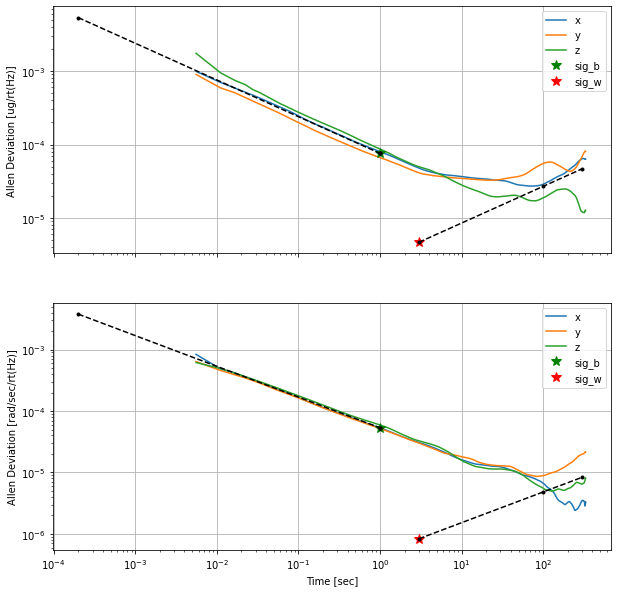

In [97]:
plot(TAU_0, DATA_AXES)

In [96]:
params = {
    "accelerometer": {
        "noise_density": biasGyroW[0],
        "random_walk": biasAccB[0]
    },
    "gyroscope": {
        "noise_density": biasGyroW[0],
        "random_walk": biasGyroB[0]
    }
}

print(params)

{'accelerometer': {'noise_density': 5.33367574767271e-05, 'random_walk': 1.7320508075688772}, 'gyroscope': {'noise_density': 5.33367574767271e-05, 'random_walk': 1.7320508075688772}}


In [98]:
storage.write("imu_params.json", params)

In [99]:
!cat imu_params.json

{"accelerometer": {"noise_density": 5.33367574767271e-05, "random_walk": 1.7320508075688772}, "gyroscope": {"noise_density": 5.33367574767271e-05, "random_walk": 1.7320508075688772}}

In [18]:
DATA_AXES

{'Acc': [4, 5, 6], 'Gyro': [1, 2, 3]}